<a href="https://colab.research.google.com/github/NARAEIM/tp2-da/blob/jennlee/rf_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


# data preparation

## library import

결정트리는 훈련 데이터에 대한 제약 사항이 거의 없는 유연한 모델이기 때문에 과적합 될 위험이 있습니다.
결정트리는 작은 데이터 변동으로도 다른 트리가 생성될 수 있기 때문에 불안정할 수 있습니다.
이러한 문제는 앙상블 기법 중 배깅-bagging을 대표하는 모델인 랜덤포레스트를 사용하면 쉽게 해결할 수 있습니다.

배깅은 훈련 데이터에서 무작위로 복원 추출(bootstrap)한 샘플로 여러 기본 모델을 만들어 각 개별 모델의 예측 결과를 종합하여 최종 예측을 하는 방법입니다.
이런 방법은 예측을 하는 과정에서 랜덤성을 부여하고 랜덤하게 만들어진 기본 모델을 종합하면서 분산을 줄여 과적합을 피할 수 있게 합니다.

분류문제일 경우 다수결로 가장 많은 모델들이 선택한 범주로 예측합니다.

랜덤포레스트는 결정트리를 기본모델로 사용하는 앙상블 기법입니다.
기본모델인 결정트리들은 독립적으로 만들어지며 각각의 기본모델이 랜덤으로 예측하는 성능보다 좋을 경우 이 기본모델을 합치는 과정에서 에러가 상쇄되어 랜덤포레스트는 더 정확한 예측을 할 수 있습니다.
랜덤포레스트는 두 가지 랜덤성을 갖고 있습니다.
1. 랜덤포레스트에서 학습되는 트리들은 배깅을 통해 만들어집니다.(bootstrap = true) 이때 각 기본모델에 사용되는 데이터가 랜덤으로 선택됩니다.
2. 랜덤포레스트의 기본 모델들은 노드를 분할할 때 특성 n개 중 일부분 k개의 특성을 랜덤하게 선택(sampling) 하여 이 안에서 최적의 특성을 찾아내어 분할합니다.
  이때 k개는 일반적으로 $log_2 n$ 을 사용합니다.

In [ ]:
!pip install category_encoders
!pip install pandas-profiling==3.1.0
! pip install eli5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.2/261.2 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.1/303.1 kB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 kB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 kB 54.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 95.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 32.0 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=dd8fe8002d544e052f59d58841ded77d604609bd5e6e031e3f195a3d3f46bd2f
  Stored in directory: /root/.cache/pip/wheels/dd/91/29/a79cecb328d01739e64017b6fb9a1ab9d8cb1853098ec5966d
Successfully built htmlmin
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 2.1.3
    Uninstalling Markup

In [ ]:
# import library

import numpy as np
import pandas as pd

import sklearn
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

from category_encoders import OrdinalEncoder

import eli5
from eli5.sklearn import PermutationImportance

from sklearn.model_selection import GridSearchCV
# random.seed(42)

## data description
customer_id : 고객아이디 <br>
gender : 성별 <br>
home_location : 지역위치 <br>
first_join_date : 처음 가입 날짜 <br>
age_segment : 나이 그룹 <br>
RFM_Segment : RFM 그룹 <br>
low : 하위 10% 로 구매한 비율 <br>high : 상위 10% 로 구매한 비율 <br>
book_cnt : 구매 횟수 <br>
time / event : 이벤트 평균 길이(s) <br>
add_book_mean : add_to_cart 에서 booking 사이에 평균 시간 (days) <br>
revisit : 평균 재방문 주기 session_cnt : 방문횟수(session 수) <br>
add_last_event_ratio : add_to_cart 로 끝나는 세션의 비율 <br>
promo_use_ratio : 프로모션 적용한 구매 비율 <br>
average_revenue : 세션당 객단가 <br>
churn : 이탈 여부 (target)

categorical data: home_location, age_segment, rfm_Segment <br>
binary data: gender<br>
continuous data: customer_id, low, high,book_cnt,time/event,

## data preprocessing

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/co_note/project/churn_modeling/feature_target.csv')
df.head()

,customer_id,gender,home_location,age_segment,RFM_Segment,low,high,book_cnt,time/event,add_book_mean,revisit,session_cnt,add_last_event_ratio,promo_use_ratio,average_revenue,R,F,M,churn
0,7279,M,Nusa Tenggara Barat,Early 30s(31-35),322.0,0.135593,0.067797,4.0,239.714286,0.205197,57529.5,37.0,0.0,0.25,169228.25,3,2,2,1
1,82542,M,Kalimantan Selatan,Early 20s(21-25),111.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.00,1,1,1,1
2,96453,F,Bengkulu,minor(15-20),211.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.00,2,1,1,1
3,8031,F,Jawa Barat,Late 20s(26-30),111.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.00,1,1,1,1
4,9152,F,Yogyakarta,Late 20s(26-30),111.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.00,1,1,1,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152097 entries, 0 to 152096
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   gender                152097 non-null  object 
 1   home_location         152097 non-null  object 
 2   age_segment           152097 non-null  object 
 3   RFM_Segment           152097 non-null  float64
 4   low                   152097 non-null  float64
 5   high                  152097 non-null  float64
 6   book_cnt              152097 non-null  float64
 7   time/event            152097 non-null  float64
 8   add_book_mean         152097 non-null  float64
 9   revisit               152097 non-null  float64
 10  session_cnt           152097 non-null  float64
 11  add_last_event_ratio  152097 non-null  float64
 12  promo_use_ratio       152097 non-null  float64
 13  average_revenue       152097 non-null  float64
 14  R                     152097 non-null  int64  
 15  

있는 대로 해보고, 높은 카디널리티가 영향을 끼친다면,
revisit은 시간을 그대로 넣기보단, 범위를 설정하는 것이 좋지 않을까?

first_join_date 대신 2022-08기준으로 join한지 몇일이 됐는지로 바꿈 <br>

In [ ]:
# # first join date 대신 마지막 결제일로부터 지난 일수 넣기
# df['first_join_date'] = pd.to_datetime(df['first_join_date'])
# df['first_join_date'] = (pd.to_datetime('2022-08-01') - df['first_join_date']).dt.days
# df.rename(columns={'first_join_date':'days_since_join'}, inplace=True)

In [ ]:
# # first_join_date drop 으로 결정
# df.drop('first_join_date', axis=1, inplace=True)

In [ ]:
# # Convert the time components to seconds
# df['revisit'] = pd.to_timedelta(df['revisit']).dt.total_seconds()

# # fill 0 in nan in revisit
# df['revisit'] = df['revisit'].fillna(0)

In [ ]:
# # rfm datatype from int to str
df['RFM_Segment'] = df['RFM_Segment'].astype('str')

In [ ]:
# df['R'] = df['RFM_Segment'].astype(str).str[0]
# df['F'] = df['RFM_Segment'].astype(str).str[1]
# df['M'] = df['RFM_Segment'].astype(str).str[2]

In [ ]:
# df.rename(columns={'bounce':'churn'},inplace=True)

In [ ]:
# df['churn'] = df.pop('churn')

In [ ]:
# df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152097 entries, 0 to 152096
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   customer_id           152097 non-null  int64  
 1   gender                152097 non-null  object 
 2   home_location         152097 non-null  object 
 3   age_segment           152097 non-null  object 
 4   RFM_Segment           152097 non-null  object 
 5   low                   152097 non-null  float64
 6   high                  152097 non-null  float64
 7   book_cnt              152097 non-null  float64
 8   time/event            152097 non-null  float64
 9   add_book_mean         152097 non-null  float64
 10  revisit               152097 non-null  float64
 11  session_cnt           152097 non-null  float64
 12  add_last_event_ratio  152097 non-null  float64
 13  promo_use_ratio       152097 non-null  float64
 14  average_revenue       152097 non-null  float64
 15  

In [ ]:
df.to_csv('/content/drive/MyDrive/co_note/project/churn_modeling/feature_target.csv', index=False)

In [ ]:
# shipment fee 를 합치고 싶었는데...안되게쓔ㅠㅠ
# def func(x):
#     if x <= 0:
#         return 1
#     elif x <= 5000:
#         return 2
#     elif x <= 10000:
#         return 3
#     elif x <= 15000:
#         return 4
#     else:
#         return 5


# df['shipments_fee'] = df['shipment_fee'].apply(func)

## EDA

In [ ]:
df.drop('customer_id', axis=1, inplace=True)

In [ ]:
# data imbalance 확인
df['churn'].value_counts()

1    115270
0     36827
Name: churn, dtype: int64

In [ ]:
import plotly.graph_objects as go

values = df['churn'].value_counts().values
labels = df['churn'].unique()

colors = ['RGBA(82, 78, 200, 0.8)', 'RGBA(192, 192, 192, 0.8)']
fig = go.Figure(data=go.Bar(x=labels, y=values, text=values, textposition='outside', marker=dict(color=colors)))
fig.update_layout(title='Churn Data Ratio')

fig.update_layout(  # adjust fig size
    width=500,
    height=600
)

fig.update_xaxes(ticktext=['No Churn', 'Churn'], tickvals=[0, 1])
fig.update_xaxes(title_text='Churn Status')
fig.update_yaxes(title_text='Count')

# Adjust the text
fig.update_traces(textfont=dict(color='black'), insidetextfont=dict(color='black'))

fig.show()

In [ ]:
# cardinality 확인 (object type에 관해서만 해당))
df.describe(exclude="number").T.sort_values(by="unique")

,count,unique,top,freq
gender,152097,2,F,97632
age_segment,152097,6,Early 20s(21-25),40596
home_location,152097,33,Jakarta Raya,28164


In [ ]:
df.describe()

,RFM_Segment,low,high,book_cnt,time/event,add_book_mean,revisit,session_cnt,add_last_event_ratio,promo_use_ratio,average_revenue,R,F,M,churn
count,152097.00000,152097.000000,152097.000000,152097.000000,152097.000000,152097.000000,1.520970e+05,152097.000000,152097.000000,152097.000000,1.520970e+05,152097.000000,152097.000000,152097.000000,152097.000000
mean,216.63303,0.034380,0.034425,0.551181,49.531438,0.826568,4.300912e+04,5.796196,0.036683,0.079930,1.597587e+05,2.001558,1.497722,1.499990,0.757872
std,85.24619,0.069767,0.070042,1.435087,126.351425,2.324868,1.324437e+05,14.982306,0.100819,0.239741,4.544692e+05,0.816615,0.499996,0.500002,0.428373
min,111.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,1.000000,1.000000,1.000000,0.000000
25%,111.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,1.000000,1.000000,1.000000,1.000000
50%,222.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,2.000000,1.000000,1.000000,1.000000
75%,322.00000,0.048780,0.050000,1.000000,24.333333,0.013083,2.023619e+04,4.000000,0.000000,0.000000,1.806615e+05,3.000000,2.000000,2.000000,1.000000
max,322.00000,1.000000,1.000000,75.000000,1619.560606,29.389595,2.643901e+06,388.000000,1.000000,1.000000,1.526086e+07,3.000000,2.000000,2.000000,1.000000


# baseline

In [ ]:
target = 'churn'

# split train, val, and test set
train, val = train_test_split(df, train_size=0.8, stratify=df['churn'], random_state=2)
val, test = train_test_split(val, train_size=0.8, stratify=val['churn'], random_state=2)
print(train.shape)
print(val.shape)
print(test.shape)

# split feature, target
def split_x_y(df):
    x,y = df.drop(target, axis=1), df[target]
    return x,y

X_train, y_train = split_x_y(train)
X_val, y_val = split_x_y(val)
X_test, y_test = split_x_y(test)

(121677, 18)
(24336, 18)
(6084, 18)


In [ ]:
# baseline
base = y_train.mode()[0]
baseline = [base] * len(y_train)
baseline_accuracy = accuracy_score(y_train, baseline)
print(f'기준모델의 accuracy은 {baseline_accuracy.round(3)} 입니다')

기준모델의 accuracy은 0.758 입니다


# modeling

### base model

In [ ]:
# random forest는 decision tree를 기본모델로 한다. Decision Tree도 함께 해보자.
pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(
        min_samples_split=10,
        min_samples_leaf=5,
        criterion='gini',
        max_depth=10,
        n_estimators=3,
        class_weight={
            0: 4,  # weight for class 0 (majority class)
            1: 1   # weight for class 1 (minority class)
        },
        max_features = 20,
        random_state=42,
    )
)

pipe.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['gender', 'home_location', 'age_segment'],
                                mapping=[{'col': 'gender',
                                          'data_type': dtype('O'),
                                          'mapping': M      1
F      2
NaN   -2
dtype: int64},
                                         {'col': 'home_location',
                                          'data_type': dtype('O'),
                                          'mapping': Kalimantan Selatan      1
Jakarta Raya            2
Yogyakarta              3
Jawa Tengah             4
Jawa Barat              5
Kalimantan Barat        6
Nusa Tenggara Barat     7
Bengkulu                8
Gorontalo               9
Jawa...
                                          'data_type': dtype('O'),
                                          'mapping': non-target adults(36-)    1
Late 20s(26-30)           2
minor(15-20)              3
non-target minor(0-14)    4
Early 20s(21-25)          5
Early 30s(31-35)          6
NaN                      -2
dtype: int64}])),
                ('simpleimputer', SimpleImputer()),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight={0: 4, 1: 1}, max_depth=10,
                                        max_features=20, min_samples_leaf=5,
                                        min_samples_split=10, n_estimators=3,
                                        random_state=42))])

In [ ]:
proba = pipe.predict_proba(X_test)

threshold = 0.5

# Apply the threshold and convert probabilities to class labels
pred_labels = (proba[:, 1] >= threshold).astype(int)

classification_rep = classification_report(y_test, pred_labels, zero_division=1)
print(classification_rep)

              precision    recall  f1-score   support

           0       0.24      0.90      0.38      1473
           1       0.76      0.10      0.18      4611

    accuracy                           0.30      6084
   macro avg       0.50      0.50      0.28      6084
weighted avg       0.63      0.30      0.23      6084



In [ ]:
# train 학습, 검증셋 정확도
print("학습 정확도", pipe.score(X_train, y_train))
print("검증 정확도", pipe.score(X_val, y_val))
y_pred = pipe.predict(X_val)
print("ROC_AUC_score", roc_auc_score(y_val, y_pred))
print(classification_report(y_val, y_pred))

학습 정확도 0.32438340853242603
검증 정확도 0.3035009861932939
ROC_AUC_score 0.5040447267050229
              precision    recall  f1-score   support

           0       0.24      0.89      0.38      5893
           1       0.77      0.12      0.20     18443

    accuracy                           0.30     24336
   macro avg       0.51      0.50      0.29     24336
weighted avg       0.64      0.30      0.24     24336



roc-auc 는 0.5만 넘으면 된다 <br>
f1가 precision 과 recall의 조합

accuracy는 과적합 정도를 보는 용

1 class의 recall 값을 보기

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:43

<Axes: >

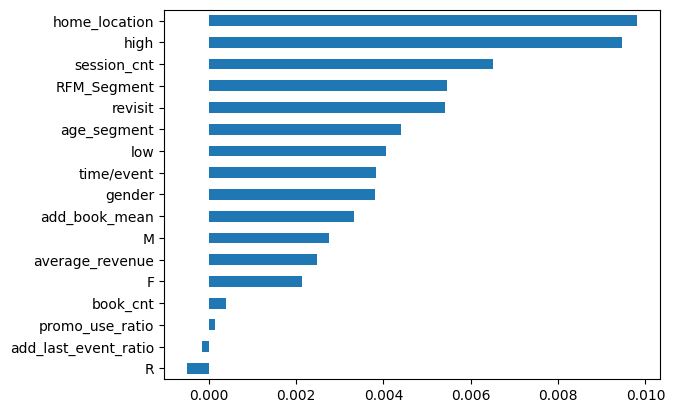

In [ ]:
# permuter 정의
permuter = PermutationImportance(
    pipe.named_steps["randomforestclassifier"],  # model
    scoring="roc_auc",  # metric
    n_iter=10,  # 다른 random seed를 사용하여 10번 반복
    random_state=2,
)

# 스코어를 다시 계산합니다.
X_val_preprocessed = pipe[0].transform(X_val)
permuter.fit(X_val_preprocessed, y_val)

feature_names = X_val_preprocessed.columns.tolist()
pi = pd.Series(permuter.feature_importances_, feature_names).sort_values()
pi.plot.barh()

In [ ]:
eli5.show_weights(
    permuter,
    top=None,  # top n 지정 가능, None 일 경우 모든 특성
    feature_names=feature_names,  # list 형식으로 넣어야 합니다
)

Weight,Feature
0.0098 ± 0.0043,home_location
0.0095 ± 0.0042,high
0.0065 ± 0.0040,session_cnt
0.0054 ± 0.0054,RFM_Segment
0.0054 ± 0.0055,revisit
0.0044 ± 0.0021,age_segment
0.0041 ± 0.0030,low
0.0038 ± 0.0034,time/event
0.0038 ± 0.0039,gender
0.0033 ± 0.0027,add_book_mean


### after dropping not important columns

In [ ]:
df_drop = df.drop(columns=['R','add_last_event_ratio','promo_use_ratio'], axis=1)

In [ ]:
target = 'churn'

# split train, val, and test set
train, val = train_test_split(df_drop, train_size=0.8, stratify=df_drop['churn'], random_state=2)
val, test = train_test_split(val, train_size=0.8, stratify=val['churn'], random_state=2)
print(train.shape)
print(val.shape)
print(test.shape)

# split feature, target
def split_x_y(df):
    x,y = df.drop(target, axis=1), df[target]
    return x,y

X_train, y_train = split_x_y(train)
X_val, y_val = split_x_y(val)
X_test, y_test = split_x_y(test)

# random forest는 decision tree를 기본모델로 한다. Decision Tree도 함께 해보자.
pipe_drop = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(
        min_samples_split=10,
        min_samples_leaf=5,
        criterion='gini',
        max_depth=10,
        n_estimators=3,
        class_weight={
            0: 4,  # weight for class 0 (majority class)
            1: 1   # weight for class 1 (minority class)
        },
        max_features = 20,
        random_state=42,
    )
)

pipe_drop.fit(X_train, y_train)

(121677, 15)
(24336, 15)
(6084, 15)


Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['gender', 'home_location', 'age_segment'],
                                mapping=[{'col': 'gender',
                                          'data_type': dtype('O'),
                                          'mapping': M      1
F      2
NaN   -2
dtype: int64},
                                         {'col': 'home_location',
                                          'data_type': dtype('O'),
                                          'mapping': Kalimantan Selatan      1
Jakarta Raya            2
Yogyakarta              3
Jawa Tengah             4
Jawa Barat              5
Kalimantan Barat        6
Nusa Tenggara Barat     7
Bengkulu                8
Gorontalo               9
Jawa...
                                          'data_type': dtype('O'),
                                          'mapping': non-target adults(36-)    1
Late 20s(26-30)           2
minor(15-20)              3
non-target minor(0-14)    4
Early 20s(21-25)          5
Early 30s(31-35)          6
NaN                      -2
dtype: int64}])),
                ('simpleimputer', SimpleImputer()),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight={0: 4, 1: 1}, max_depth=10,
                                        max_features=20, min_samples_leaf=5,
                                        min_samples_split=10, n_estimators=3,
                                        random_state=42))])

In [ ]:
# train 학습, 검증셋 정확도
print("학습 정확도", pipe_drop.score(X_train, y_train))
print("검증 정확도", pipe_drop.score(X_val, y_val))
y_pred = pipe_drop.predict(X_val)
print("ROC_AUC_score", roc_auc_score(y_val, y_pred))
print(classification_report(y_val, y_pred))

학습 정확도 0.326750330793823
검증 정확도 0.30950032873109795
ROC_AUC_score 0.5068481505829542
              precision    recall  f1-score   support

           0       0.25      0.89      0.38      5893
           1       0.78      0.12      0.21     18443

    accuracy                           0.31     24336
   macro avg       0.51      0.51      0.30     24336
weighted avg       0.65      0.31      0.26     24336



In [ ]:
# permuter 정의
permuter = PermutationImportance(
    pipe.named_steps["randomforestclassifier"],  # model
    scoring="roc_auc",  # metric
    n_iter=10,  # 다른 random seed를 사용하여 10번 반복
    random_state=2,
)

# 스코어를 다시 계산합니다.
X_val_preprocessed = pipe[0].transform(X_val)
permuter.fit(X_val_preprocessed, y_val)

feature_names = X_val_preprocessed.columns.tolist()
pi = pd.Series(permuter.feature_importances_, feature_names).sort_values()
pi.plot.barh()

ValueError: ignored

In [ ]:
eli5.show_weights(
    permuter,
    top=None,  # top n 지정 가능, None 일 경우 모든 특성
    feature_names=feature_names,  # list 형식으로 넣어야 합니다
)

Weight,Feature
0.0021 ± 0.0051,average_revenue
0.0019 ± 0.0093,add_book_mean
0.0015 ± 0.0111,time/event
0.0011 ± 0.0107,session_cnt
-0.0011 ± 0.0085,low
-0.0015 ± 0.0138,home_location
-0.0018 ± 0.0070,book_cnt
-0.0025 ± 0.0024,R
-0.0031 ± 0.0037,gender


## Tuning

In [ ]:
threshold 조정

### gridsearch

In [ ]:
pipe_drop = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(
        min_samples_split=10,
        min_samples_leaf=5,
        class_weight={
            0: 4,  # weight for class 0 (majority class)
            1: 1   # weight for class 1 (minority class)
        },
        random_state=42,
        n_jobs=-1
    )
)

In [ ]:
params = {
    'randomforestclassifier__n_estimators': [200, 300],
    'randomforestclassifier__max_features': ['auto', 'sqrt', 'log2'],
    'randomforestclassifier__max_depth' : [4, 6, 8],
    'randomforestclassifier__max_leaf_nodes' :
}

grid_search = GridSearchCV(pipe_drop, param_grid=params, scoring='roc_auc', cv=3, verbose=3)
grid_search.fit(X_train, y_train)


SyntaxError: ignored

In [ ]:
best_estimator = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Best Estimator:", best_estimator)
print("Best Parameters:", best_params)

In [ ]:
# max_depth': 6, 'max_features': 'auto', 'n_estimators': 300

In [ ]:
best_estimator = grid_search.best_estimator_

print("학습 정확도:", best_estimator.score(X_train, y_train))
print("검증 정확도:", best_estimator.score(X_val, y_val))
y_pred = best_estimator.predict(X_val)
print("ROC_AUC_score:", roc_auc_score(y_val, y_pred))
print(classification_report(y_val, y_pred))

학습 정확도: 0.8266475997928943
검증 정확도: 0.8250739644970414
ROC_AUC_score: 0.500054421562076
              precision    recall  f1-score   support

           0       0.20      0.00      0.00      1416
           1       0.83      1.00      0.90      6696

    accuracy                           0.83      8112
   macro avg       0.51      0.50      0.45      8112
weighted avg       0.72      0.83      0.75      8112



In [ ]:
# 0을 0이라고 전혀 판단하지 못하고 있음...

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:43

<Axes: >

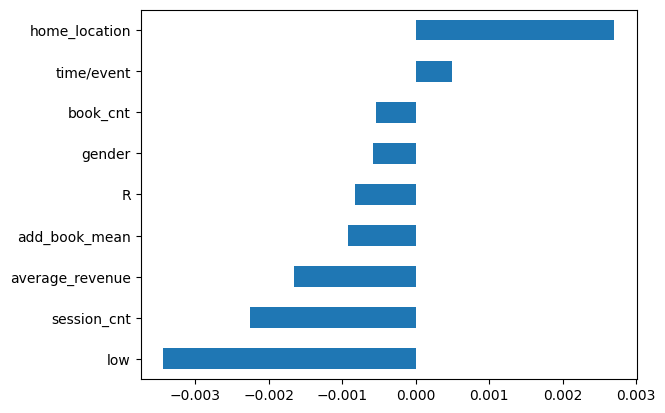

In [ ]:
permuter_grid = PermutationImportance(
    best_estimator.named_steps["randomforestclassifier"],
    scoring="roc_auc",
    n_iter=10,
    random_state=2
)

# Calculate feature importances
X_val_preprocessed = best_estimator[0].transform(X_val)
permuter_grid.fit(X_val_preprocessed, y_val)

# Plot feature importances
feature_names = X_val_preprocessed.columns.tolist()
pi = pd.Series(permuter_grid.feature_importances_, feature_names).sort_values()
pi.plot.barh()

In [ ]:
eli5.show_weights(
    permuter_grid,
    top=None,  # top n 지정 가능, None 일 경우 모든 특성
    feature_names=feature_names,  # list 형식으로 넣어야 합니다
)

Weight,Feature
0.0027 ± 0.0144,home_location
0.0005 ± 0.0079,time/event
-0.0005 ± 0.0086,book_cnt
-0.0006 ± 0.0019,gender
-0.0008 ± 0.0020,R
-0.0009 ± 0.0103,add_book_mean
-0.0017 ± 0.0078,average_revenue
-0.0023 ± 0.0073,session_cnt
-0.0034 ± 0.0028,low


### oversampling (churn = 0)

In [ ]:
pipe_drop = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(
        min_samples_split=10,
        min_samples_leaf=5,
        class_weight={
            0: 4,  # weight for class 0 (majority class)
            1: 1   # weight for class 1 (minority class)
        },
        random_state=42,
        n_jobs=-1
    )
)

# cat boost

In [ ]:
from catboost import CatBoostClassifier, Pool

ModuleNotFoundError: ignored